1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4
from scipy import stats
from scipy.special import gamma

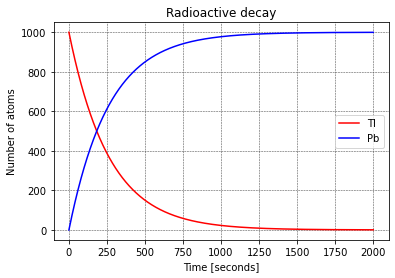

In [4]:
N_Tl = 1000 #Initial number of Tl atoms
N_Pb = 0 #Initial number of Pb atoms
t_half = 183.12 #half-life [seconds]

#def p(time):
#    return 1 - (2**(-time/t_half))

time = np.array([0])
Tl = np.array([N_Tl])
Pb = np.array([N_Pb])

t = 0 #starting time [seconds]
dt = 1 #time step [seconds]
l = np.log(2)/t_half #constant of decay

while t < 2000:
    t += dt
    time = np.append(time, t)
    aus = N_Tl
    N_Tl += -N_Tl*l*dt
    Tl = np.append(Tl, N_Tl)
    N_Pb += aus - N_Tl
    Pb = np.append(Pb, N_Pb)

plt.plot(time, Tl, 'r-', label='Tl')
plt.plot(time, Pb, 'b-', label='Pb')
plt.title('Radioactive decay')
plt.xlabel('Time [seconds]')
plt.ylabel('Number of atoms')
plt.grid(linestyle="--", linewidth=0.5, color='.25')
plt.legend(loc='best')

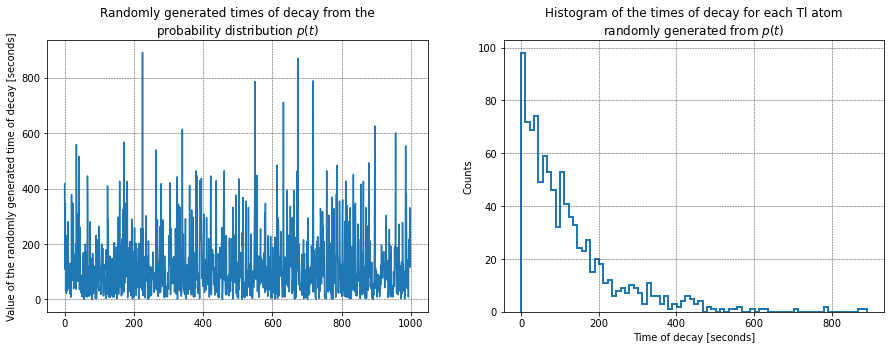

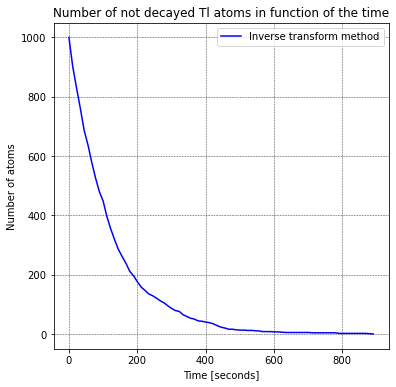

In [36]:
N_Tl = 1000 #Initial number of Tl atoms
t_half = 183.12 #half-life [seconds]
R = np.log(2)*stats.expon.rvs(scale = t_half,  size = N_Tl) 
x = np.arange(0, N_Tl)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(x, R)
ax1.set_title('Randomly generated times of decay from the\nprobability distribution $p(t)$')
ax1.set_ylabel('Value of the randomly generated time of decay [seconds]')
ax1.grid(linestyle="--", linewidth=0.5, color='.25')
ax2 = fig.add_subplot(122)
h = ax2.hist(R, histtype='step', bins=80, linewidth=2)
ax2.set_title('Histogram of the times of decay for each Tl atom\nrandomly generated from $p(t)$')
ax2.set_xlabel('Time of decay [seconds]')
ax2.set_ylabel('Counts')
ax2.grid(linestyle="--", linewidth=0.5, color='.25')

nda = np.array([N_Tl])
val = N_Tl
for i in range(len(h[0])):
    val -= h[0][i]
    nda = np.append(nda, val)

plt.figure(figsize=(6, 6))
plt.plot(h[1], nda, 'b-', label='Inverse transform method')
#plt.plot(time, Tl, 'r-', label='Analytical method')
plt.title('Number of not decayed Tl atoms in function of the time')
plt.xlabel('Time [seconds]')
plt.ylabel('Number of atoms')
plt.grid(linestyle="--", linewidth=0.5, color='.25')
plt.legend(loc='best')

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

The fraction of particles that bounce back is: 0.022253


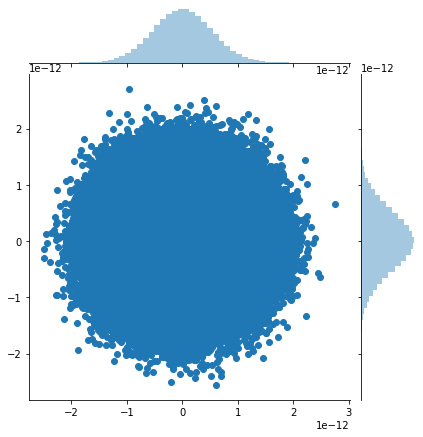

In [4]:
n = 1000000 #Number of alpha particles in the beam
a0 = 0.53E-10 #Bohr radius
sigma = a0/100
Z = 79 #Gold's atomic number
E = 7.7*(1.6E-13) #Energy 
e = 1.6E-19 #electron charge
epsilon0 = 8.85E-12 #dielectric constant
z = np.random.random(n)
theta = 2*np.pi*np.random.random(n)
#r_squared = -2*np.log(z)
r = np.sqrt(-2*(sigma**2)*np.log(z))
x = r*np.cos(theta)
y = r*np.sin(theta) #Let's suppose that the y coordinate of the gold atom is 0,
                    # so the y coordinate of each alpha particle coincides with the impact parameter b
sns.jointplot(x,y, kind='scatter');

def angle(b):
    return 2*np.arctan((Z*(e**2))/(2*np.pi*epsilon0*E*b))

bb = len(y[angle(y)>(np.pi/2)])
p = bb/n
print("The fraction of particles that bounce back is:", p)

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

<ipython-input-20-d67432b33752>:2: RuntimeWarning: divide by zero encountered in true_divide
  return (np.sin(1/(y*(2-y))))**2
<ipython-input-20-d67432b33752>:2: RuntimeWarning: invalid value encountered in sin
  return (np.sin(1/(y*(2-y))))**2


Value of the integral calculated with hit or miss method: 1.45304
The error associated with the hit or miss method is proportional to 1/sqrt(N): 0.003162277660168379
Value of the integral calculated with mean value method: 1.4532403264710405
The error associated with the mean value method is equal to: 0.0016643384388518743


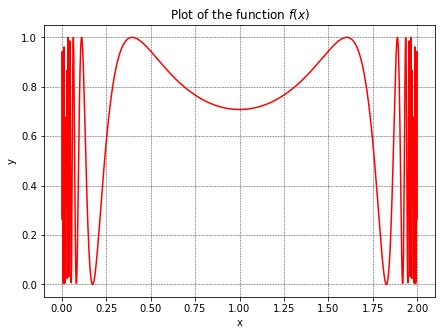

In [20]:
def f(y):
    return (np.sin(1/(y*(2-y))))**2

x = np.linspace(0, 2, 1000)

plt.figure(figsize=(7, 5))
plt.plot(x, f(x), 'r-')
plt.title('Plot of the function $f(x)$')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(linestyle="--", linewidth=0.5, color='.25')

N = 100000
#Hit or miss method
cnt = 0
for i in range(N):
    x1 = 2*np.random.random()
    y1 = np.random.random()
    if y1 < f(x1):
        cnt += 1
I1 = (2*cnt)/N
err1 = 1/np.sqrt(N)
print("Value of the integral calculated with hit or miss method:", I1)
print("The error associated with the hit or miss method is proportional to 1/sqrt(N):", err1)

#Mean value method
x2 = 2*np.random.random(N)
y2 = f(x2)
I2 = 2*np.mean(y2)
err2 = (2*np.sqrt(np.var(y2)))/np.sqrt(N)
print("Value of the integral calculated with mean value method:", I2)
print("The error associated with the mean value method is equal to:", err2)

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [40]:
def f(x1, x2):
    if (x1**2)+(x2**2) <= 1:
        val = 1
    else:
        val = 0
    return val

N = 500000
count = 0
for i in range(N):
    X = (2*np.random.random((2,)))-1
    count += f(X[0], X[1])
I = (4*count)/N
print("Area of a circle of unit radius:\n")
print("True value of the area: ", np.pi)
print("Area computed with hit or miss method: ", I)

Area of a circle of unit radius:

True value of the area:  3.141592653589793
Area computed with hit or miss method:  3.144656


In [38]:
def f(x):
    sq_norm = 0
    for xj in x:
        sq_norm += xj**2
    if sq_norm <= 1:
        val = 1
    else:
        val = 0
    return val

N = 500000
dim = 10 #Dimension of the sphere
count = 0
for i in range(N):
    X = (2*np.random.random((dim,)))-1
    count += f(X)
I = ((2**dim)*count)/N
V = (np.pi**(dim/2))/(gamma((dim/2)+1))
print("Volume of a", dim, "dimensional sphere of unit radius:\n")
print("True value of the volume: ", V)
print("Volume computed with hit or miss method: ", I)

Volume of a 10 dimensional sphere of unit radius:

True value of the volume:  2.550164039877345
Volume computed with hit or miss method:  2.586624


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

Value of the integral calculated with importance sampling method:  0.8336812275688692


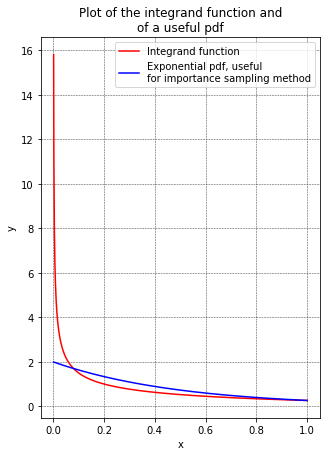

In [55]:
def f(y):
    return (y**(-1/2))/(np.exp(y)+1)

def w(z):
    return 1/np.sqrt(z)

#def g(t):
#    return 1/(np.exp(t)+1)

X = np.linspace(0.001, 1.001, 1000)
mu = 2

plt.figure(figsize=(5, 7))
plt.plot(X, f(X), 'r-', label='Integrand function')
plt.plot(X, mu*np.exp(-mu*X), 'b-', label='Exponential pdf, useful\nfor importance sampling method')
plt.title('Plot of the integrand function and\nof a useful pdf')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(linestyle="--", linewidth=0.5, color='.25')
plt.legend(loc='best')

W = 2 #It's the integral between 0 and 1 of w(x) which is analitically solvable and is equal to 2
N = 100000
r = stats.expon.rvs(scale = 1/mu,  size = N) #Random generated numbers from an exponential pdf
x = r[r <= 1]
g = f(x)/w(x)
I = np.mean(g)*W
print("Value of the integral calculated with importance sampling method: ", I)